# understanding AC pair reactivity trends

# Summary

What governs low reactivity in CA pairs? <br>
Generally Cs are lower than As [All residues](#all-residues) <br>
There are trends in C reactivity based on stacking prefering C/U [Stacking trends](#stacking-trends)


# Setup

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ks_2samp, pearsonr, linregress
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import statsmodels.api as sm
from tabulate import tabulate
import py3Dmol

from dms_3d_features.plotting import (
    plot_pop_avg_from_row,
    plot_motif_boxplot_stripplot,
    plot_violins_w_percent,
    plot_violins_w_percent_groups,
    format_small_plot,
)
from dms_3d_features.format_tables import (
    dataframe_column_table,
    generate_threshold_summary,
)

## extra functions

In [3]:
def visualize_molecule(row, width=400, height=300):
    viewer = py3Dmol.view(width=width, height=height)
    viewer.addModel(open("../" + row["pdb_path"], "r").read(), "pdb")

    # Set color scheme for nucleotides
    nucleotide_colors = {"A": "red", "U": "green", "C": "blue", "G": "orange"}
    for nuc, color in nucleotide_colors.items():
        viewer.setStyle({"resn": nuc}, {"stick": {"color": color}})

    viewer.zoomTo()

    residue_number = row["pdb_r_pos"]
    viewer.addStyle({"resi": str(residue_number)}, {"stick": {"color": "magenta"}})

    # Highlight N1 for A or N3 for C
    if row["r_nuc"] == "A":
        viewer.addStyle(
            {"resi": str(residue_number), "atom": "N1"},
            {"sphere": {"radius": 1.0, "color": "magenta"}},
        )
    elif row["r_nuc"] == "C":
        viewer.addStyle(
            {"resi": str(residue_number), "atom": "N3"},
            {"sphere": {"radius": 1.0, "color": "magenta"}},
        )

    return viewer

### plotting

In [4]:
def plot_side_diff_violinplot(df_pos, color="tab:red"):
    df_pos["side_diff"] = [
        abs(int(x.split("x")[0]) - int(x.split("x")[1])) for x in df_pos["m_token"]
    ]
    df_pos["side_diff"] = df_pos["side_diff"].astype(str)
    df_pos.sort_values("side_diff", inplace=True, ascending=True)

    # Calculate percentage over threshold for each side_diff
    percentages = (
        df_pos.groupby("side_diff")
        .apply(lambda x: (x["ln_r_data"] < -5.45).mean() * 100)
        .round(2)
    )

    fig, ax = plt.subplots(figsize=(2.0, 1.5), dpi=200)
    ax = sns.violinplot(
        data=df_pos,
        x="ln_r_data",
        y="side_diff",
        density_norm="width",
        color=color,
        linewidth=0.5,
        ax=ax,
    )
    ax.axvline(-5.45, color="black", linestyle="--", lw=0.5)
    ax.set_xlim(-10, -1)
    ax.set_xticks([-10, -8, -6, -4, -2])
    ax.set_xlabel("ln(Mutation Fraction)", labelpad=2)
    ax.set_ylabel("Diff. in num nucleotides", labelpad=2)
    # Add percentage labels
    for i, (side_diff, percentage) in enumerate(percentages.items()):
        ax.text(-8, i + 0.03, f"{percentage:.2f}%", va="center", ha="right")
    format_small_plot(ax)

    return fig, ax

In [5]:
def plot_residue_trends(df, color="tab:gray"):
    fig = plt.figure(figsize=(3.0, 3.0), dpi=200)
    gs = fig.add_gridspec(2, 2, width_ratios=[1, 1], height_ratios=[1, 1])
    ax1 = fig.add_subplot(gs[0, 0])
    ax2 = fig.add_subplot(gs[1, 0])
    ax3 = fig.add_subplot(gs[:, 1])

    # 5' Residue
    data_range = df["ln_r_data"].max() - df["ln_r_data"].min()
    extra_space = 0.4 * data_range
    xlim_min = df["ln_r_data"].min() - extra_space
    xlim_max = df["ln_r_data"].max()

    plot_violins_w_percent(
        df,
        "ln_r_data",
        "p5_res",
        color=color,
        gt_lt="less",
        xlim=(xlim_min, xlim_max),
        text_offset=extra_space,
        sorted_by_mean=True,
        ax=ax1,
    )
    ax1.set_ylabel("5' Residue", labelpad=2)
    ax1.set_xlabel("ln(Mutational Fraction)", labelpad=2)
    format_small_plot(ax1)

    # 3' Residue
    plot_violins_w_percent(
        df,
        "ln_r_data",
        "p3_res",
        color=color,
        gt_lt="less",
        xlim=(xlim_min, xlim_max),
        text_offset=extra_space,
        sorted_by_mean=True,
        ax=ax2,
    )
    ax2.set_ylabel("3' Residue", labelpad=2)
    ax2.set_xlabel("ln(Mutational Fraction)", labelpad=2)
    format_small_plot(ax2)

    # Residue Stack
    plot_violins_w_percent(
        df,
        "ln_r_data",
        "r_stack",
        color=color,
        gt_lt="less",
        xlim=(xlim_min, xlim_max),
        text_offset=extra_space,
        sorted_by_mean=True,
        ax=ax3,
    )
    ax3.set_ylabel("Residue Stack", labelpad=2)
    ax3.set_xlabel("ln(Mutational Fraction)", labelpad=2)
    format_small_plot(ax3)
    plt.tight_layout()

### summary tables

In [6]:
def create_summary_table(df, y_column):
    # Calculate percentages and counts
    summary = []
    for y_value in df[y_column].unique():
        group = df[df[y_column] == y_value]
        percent_over = (group["ln_r_data"] < -5.45).mean() * 100
        count = len(group)
        summary.append([y_value, f"{percent_over:.2f}%", count])

    # Sort by percentage descending
    summary.sort(key=lambda x: float(x[1][:-1]), reverse=True)

    # Create table
    headers = [y_column, "% Under -5.45", "Count"]
    table = tabulate(summary, headers=headers, tablefmt="pipe", floatfmt=".2f")

    print(f"Summary table for {y_column}:")
    print(table)

In [7]:
def analyze_flanking_pairs(df):
    # Calculate the mean of r_data_ratio for each combination of m_second_flank_bp_5p and m_second_flank_bp_3p
    mean_r_data_ratio = (
        df.groupby(["m_second_flank_bp_5p", "m_second_flank_bp_3p"])["r_data_ratio"]
        .mean()
        .reset_index()
    )
    # Pivot the table to create a matrix-like structure
    pivot_table = mean_r_data_ratio.pivot(
        index="m_second_flank_bp_5p",
        columns="m_second_flank_bp_3p",
        values="r_data_ratio",
    )
    # Sort the index and columns alphabetically
    pivot_table = pivot_table.sort_index().sort_index(axis=1)
    # Display the results as a styled table
    display(pivot_table.style.format("{:.1f}").background_gradient(cmap="YlOrRd"))
    # Calculate the count of occurrences for each combination
    count_table = (
        df.groupby(["m_second_flank_bp_5p", "m_second_flank_bp_3p"])
        .size()
        .reset_index(name="count")
    )
    pivot_count = count_table.pivot(
        index="m_second_flank_bp_5p", columns="m_second_flank_bp_3p", values="count"
    )
    pivot_count = pivot_count.sort_index().sort_index(axis=1)
    # Display the count table
    display(pivot_count.style.format("{:.1f}").background_gradient(cmap="Blues"))

In [8]:
def display_heatmap_table(df, index_col, column_col, value_col):
    from IPython.display import display, HTML

    # Calculate mean, std, and count
    mean_values = df.groupby([index_col, column_col])[value_col].mean().unstack()
    std_values = df.groupby([index_col, column_col])[value_col].std().unstack()
    count_values = df.groupby([index_col, column_col]).size().unstack()

    # Sort index and columns alphabetically
    for table in [mean_values, std_values, count_values]:
        table.sort_index(inplace=True)
        table.sort_index(axis=1, inplace=True)

    # Style the tables
    mean_styled = mean_values.style.format("{:.1f}").background_gradient(cmap="YlOrRd")
    std_styled = std_values.style.format("{:.2f}").background_gradient(cmap="Greens")
    count_styled = count_values.style.format("{:.0f}").background_gradient(cmap="Blues")

    # Combine tables horizontally
    combined_html = f"""
    <div style="display: flex; justify-content: space-around;">
        <div>
            <h3>Mean</h3>
            {mean_styled.to_html()}
        </div>
        <div>
            <h3>Std Dev</h3>
            {std_styled.to_html()}
        </div>
        <div>
            <h3>Count</h3>
            {count_styled.to_html()}
        </div>
    </div>
    """

    # Display the combined table
    display(HTML(combined_html))

### misc

In [9]:
def assign_stack_type(row):
    if row["both_pyrimidine"]:
        return "both_pyrimidine"
    elif row["both_purine"]:
        return "both_purine"
    else:
        return "mixed"

In [10]:
def calculate_side_diff(x):
    sides = x.split("x")
    return str(abs(int(sides[0]) - int(sides[1])))

## load data

In [11]:
DATA_PATH = "../data"

In [12]:
df = pd.read_json(f"{DATA_PATH}/raw-jsons/residues/pdb_library_1_residues.json")
df_ca = df.query("r_nuc == 'C' and r_type == 'NON-WC' and likely_pair == 'CA'").copy()
df_ac = df.query("r_nuc == 'A' and r_type == 'NON-WC' and likely_pair == 'AC'").copy()
# pdb dataframe
df_pdb = pd.read_json(f"{DATA_PATH}/raw-jsons/residues/pdb_library_1_residues_pdb.json")
df_pdb = df_pdb.query("not m_token.isnull()").copy()
df_pdb["side_diff"] = df_pdb["m_token"].apply(calculate_side_diff)
df_pdb_ca = df_pdb.query(
    "r_nuc == 'C' and r_type == 'NON-WC' and pdb_r_pair == 'C-A' and no_of_interactions == 1"
).copy()
df_pdb_ac = df_pdb.query(
    "r_nuc == 'A' and r_type == 'NON-WC' and pdb_r_pair == 'A-C' and no_of_interactions == 1"
).copy()

In [13]:
dataframe_column_table(df_pdb)

                  0                  1                          2                    3
         m_sequence              r_nuc                  pdb_r_pos          partner_nuc
    pdb_partner_pos             r_type              pdb_r_bp_type           pdb_r_pair
no_of_conformations no_of_interactions no_of_partner_interactions             pdb_name
           pdb_path            pdb_res                both_purine      both_pyrimidine
         constructs        likely_pair              m_flank_bp_5p        m_flank_bp_3p
      m_orientation              m_pos       m_second_flank_bp_5p m_second_flank_bp_3p
        m_structure            m_token                     n_pdbs            pair_type
             p5_res            p5_type                     p3_res              p3_type
             r_data          r_loc_pos                      r_pos              r_stack
          ln_r_data            z_score             r_data_outlier       pair_pdb_r_pos
          side_diff                NaN     

# All residues

In [14]:
df_ca = df.query("r_nuc == 'C' and r_type == 'NON-WC' and likely_pair == 'CA'").copy()
print(len(df_ca["m_sequence"].unique()))

203


In [15]:
df_ca = df.query("r_nuc == 'C' and r_type == 'NON-WC' and likely_pair == 'CA'").copy()
df_ac = df.query("r_nuc == 'A' and r_type == 'NON-WC' and likely_pair == 'AC'").copy()
df_merge = pd.concat([df_ca, df_ac])
generate_threshold_summary(df_merge, "r_nuc", greater_than=False)

Summary table for r_nuc:
| r_nuc   | % < -5.45   |   Count |
|:--------|:------------|--------:|
| C       | 6.76%       |   18410 |
| A       | 3.43%       |   18410 |


In [16]:
df_ca = df.query(
    "r_nuc == 'C' and r_type == 'NON-WC' and likely_pair == 'CA' and m_token == '1x1'"
).copy()
df_ac = df.query(
    "r_nuc == 'A' and r_type == 'NON-WC' and likely_pair == 'AC' and m_token == '1x1'"
).copy()
df_merge = pd.concat([df_ca, df_ac])
generate_threshold_summary(df_merge, "r_nuc", greater_than=False)

Summary table for r_nuc:
| r_nuc   | % < -5.45   |   Count |
|:--------|:------------|--------:|
| C       | 33.09%      |     674 |
| A       | 17.21%      |     674 |


## Stacking trends

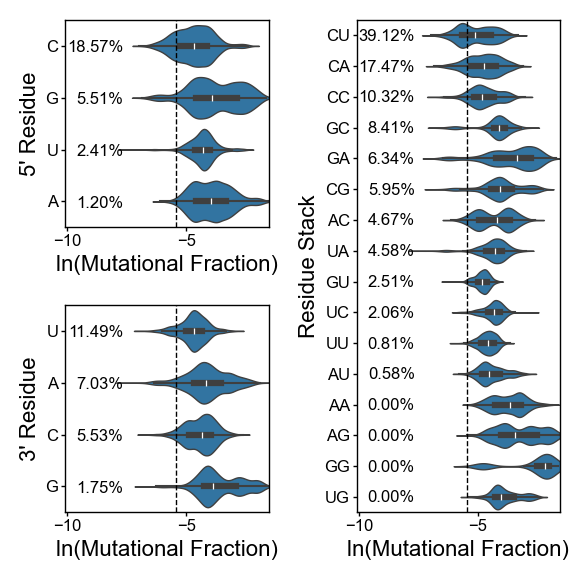

In [17]:
df_ca = df.query("r_nuc == 'C' and r_type == 'NON-WC' and likely_pair == 'CA'").copy()
plot_residue_trends(df_ca, color="tab:blue")

In [18]:
create_summary_table(df_ca, "r_stack")

Summary table for r_stack:
| r_stack   | % Under -5.45   |   Count |
|:----------|:----------------|--------:|
| CU        | 39.12%          |    1025 |
| CA        | 17.47%          |    1935 |
| CC        | 10.32%          |     959 |
| GC        | 8.41%           |     440 |
| GA        | 6.34%           |    1641 |
| CG        | 5.95%           |     874 |
| AC        | 4.67%           |    1136 |
| UA        | 4.58%           |    2272 |
| GU        | 2.51%           |     438 |
| UC        | 2.06%           |    1410 |
| UU        | 0.81%           |    1229 |
| AU        | 0.58%           |    1033 |
| UG        | 0.00%           |    1030 |
| GG        | 0.00%           |     241 |
| AA        | 0.00%           |    1916 |
| AG        | 0.00%           |     831 |


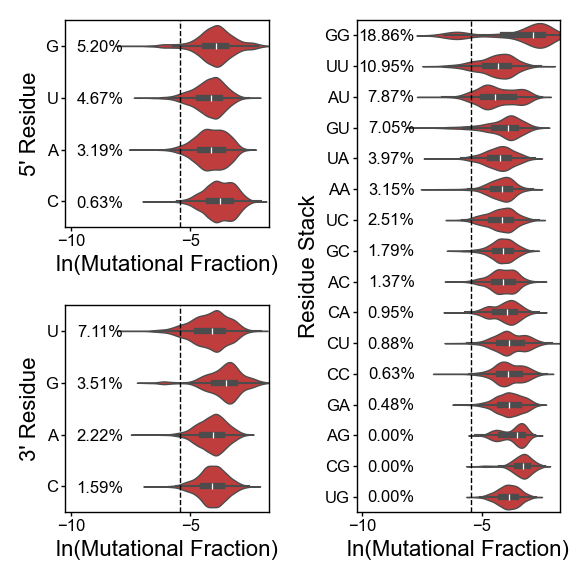

In [19]:
df_ac = df.query("r_nuc == 'A' and r_type == 'NON-WC' and likely_pair == 'AC'").copy()
plot_residue_trends(df_ac, color="tab:red")

/opt/homebrew/Caskroom/miniconda/base/envs/py3/lib/python3.8/site-packages/dms_3d_features/plotting.py:438: UserWarning: The palette list has more values (10) than needed (3), which may not be intended.
  sns.violinplot(


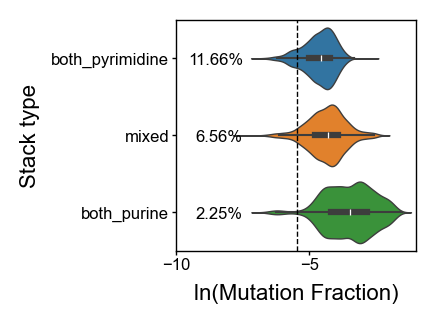

In [20]:
fig, ax = plt.subplots(figsize=(2.0, 1.5), dpi=200)
df_ca = df.query("r_nuc == 'C' and r_type == 'NON-WC' and likely_pair == 'CA'").copy()
df_ca["stack_type"] = df_ca.apply(assign_stack_type, axis=1)
ax = plot_violins_w_percent(
    df_ca,
    "ln_r_data",
    "stack_type",
    color=None,
    gt_lt="less",
    xlim=(-10, -1),
    sorted_by_mean=True,
    ax=ax,
)
ax.set_ylabel("Stack type")
ax.set_xlabel("ln(Mutation Fraction)")
format_small_plot(ax)

In [21]:
create_summary_table(df_ac, "r_stack")

Summary table for r_stack:
| r_stack   | % Under -5.45   |   Count |
|:----------|:----------------|--------:|
| GG        | 18.86%          |     525 |
| UU        | 10.95%          |    1425 |
| AU        | 7.87%           |    1232 |
| GU        | 7.05%           |    1064 |
| UA        | 3.97%           |    1033 |
| AA        | 3.15%           |     793 |
| UC        | 2.51%           |    2035 |
| GC        | 1.79%           |    1512 |
| AC        | 1.37%           |    2051 |
| CA        | 0.95%           |     843 |
| CU        | 0.88%           |    1018 |
| CC        | 0.63%           |    1741 |
| GA        | 0.48%           |     841 |
| AG        | 0.00%           |     630 |
| CG        | 0.00%           |     849 |
| UG        | 0.00%           |     818 |


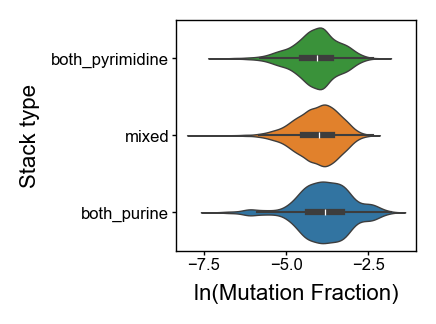

In [22]:
fig, ax = plt.subplots(figsize=(2.0, 1.5), dpi=200)
df_ca = df.query("likely_pair == 'AC'").copy()
df_ca["stack_type"] = df_ca.apply(assign_stack_type, axis=1)
sns.violinplot(
    data=df_ca,
    y="stack_type",
    x="ln_r_data",
    hue="stack_type",
    order=["both_pyrimidine", "mixed", "both_purine"],
    ax=ax,
    linewidth=0.5,
)
ax.set_ylabel("Stack type")
ax.set_xlabel("ln(Mutation Fraction)")
format_small_plot(ax)

## Ratio in reactivity

In [23]:
df_ca = df.query(
    "r_type == 'NON-WC' and (likely_pair == 'CA' or likely_pair == 'AC')"
).copy()
new_rows = []
for i, group in df_ca.groupby(["m_sequence", "constructs", "m_pos"]):
    if len(group) == 2:
        sorted_group = group.sort_values(by="r_nuc", ascending=True)
        new_row = sorted_group.iloc[0].copy()
        new_row["r_data_ratio"] = (
            sorted_group.iloc[1]["r_data"] / sorted_group.iloc[0]["r_data"]
        )
        new_row["r_data_other"] = sorted_group.iloc[1]["r_data"]
        new_row["r_stack_other"] = sorted_group.iloc[1]["r_stack"]
        new_row["p5_res_other"] = sorted_group.iloc[1]["p5_res"]
        new_row["p3_res_other"] = sorted_group.iloc[1]["p3_res"]
        new_rows.append(new_row)
df_ca_combined = pd.DataFrame(new_rows)

In [24]:
df_ca_combined = df_ca_combined.sort_values(by="r_data_ratio", ascending=False)

/var/folders/wj/4ksnmwbd59g7774kql3ctq7h0000gq/T/ipykernel_48271/2228824590.py:5: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  ax.set_xlim(0, 10)


(0.01568139363047442, 10)

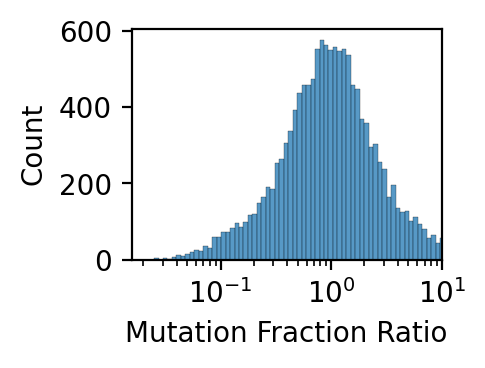

In [25]:
fig, ax = plt.subplots(figsize=(2.0, 1.5), dpi=200)
sns.histplot(df_ca_combined["r_data_ratio"], bins=100, ax=ax, log_scale=(True, False))
ax.set_xlabel("Mutation Fraction Ratio")
ax.set_ylabel("Count")
ax.set_xlim(0, 10)

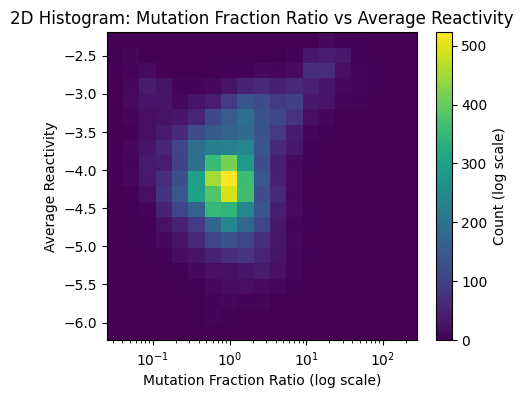

In [26]:
# Calculate average reactivity
df_ca_combined["avg_reactivity"] = np.log(
    (df_ca_combined["r_data"] + df_ca_combined["r_data_other"]) / 2
)

# Create a figure for the 2D histogram
fig, ax = plt.subplots(figsize=(5, 4))

# Create bins in log space for x-axis (Mutation Fraction Ratio)
x_bins = np.logspace(
    np.log10(df_ca_combined["r_data_ratio"].min()),
    np.log10(df_ca_combined["r_data_ratio"].max()),
    num=20,
)

# Create a 2D histogram with logarithmic x-axis bins
h = ax.hist2d(
    df_ca_combined["r_data_ratio"],
    df_ca_combined["avg_reactivity"],
    bins=(x_bins, 20),
    cmap="viridis",
)

# Set labels and title
ax.set_xlabel("Mutation Fraction Ratio (log scale)")
ax.set_ylabel("Average Reactivity")
ax.set_title("2D Histogram: Mutation Fraction Ratio vs Average Reactivity")

# Set x-axis to log scale
ax.set_xscale("log")

# Add a colorbar
cbar = fig.colorbar(h[3], ax=ax)
cbar.set_label("Count (log scale)")

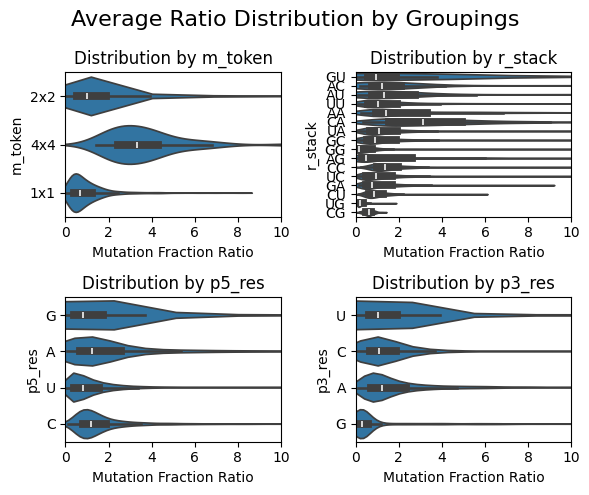

In [27]:
# Calculate average ratio for different groupings
groupings = ["m_token", "r_stack", "p5_res", "p3_res"]

fig, axes = plt.subplots(2, 2, figsize=(6, 5))
fig.suptitle("Average Ratio Distribution by Groupings", fontsize=16)

for idx, group in enumerate(groupings):
    row = idx // 2
    col = idx % 2

    # Create violin plot
    sns.violinplot(
        x="r_data_ratio",
        y=group,
        data=df_ca_combined,
        ax=axes[row, col],
        orient="h",
        density_norm="width",
    )

    axes[row, col].set_title(f"Distribution by {group}")
    axes[row, col].set_xlabel("Mutation Fraction Ratio")
    axes[row, col].set_ylabel(group)
    axes[row, col].set_xlim(0, 10)

plt.tight_layout()
plt.show()

In [28]:
average_ratios = (
    df_ca_combined.query("has_pdbs == True")
    .groupby("m_sequence")["r_data_ratio"]
    .mean()
    .sort_values(ascending=False)  # Changed to ascending=True for lowest ratios
)

# Get the top 10 unique m_sequences with the lowest average ratio
top_10_sequences = average_ratios.tail(10)

# Create a table-like output
print("Bottom 10 Unique m_sequences with Lowest Average Ratio:")
print("-" * 70)
print(f"{'m_sequence':<15} | {'Average r_data_ratio':>20} | {'PDB Path':>30}")
print("-" * 70)
for sequence, ratio in top_10_sequences.items():
    # Get the PDB path for the current sequence
    pdb_path = df_ca_combined.query(f"m_sequence == '{sequence}' and has_pdbs == True")[
        "pdb_path"
    ].iloc[0]
    if isinstance(pdb_path, list):
        pdb_path = pdb_path[0]  # Take the first PDB path if it's a list
    print(f"{sequence:<15} | {ratio:>20.2f} | {pdb_path:>30}")
print("-" * 70)

Bottom 10 Unique m_sequences with Lowest Average Ratio:
----------------------------------------------------------------------
m_sequence      | Average r_data_ratio |                       PDB Path
----------------------------------------------------------------------
AAC&GCU         |                 1.46 | data/pdbs_w_2bp/AAC_GCU/TWOWAY.5XXU.1-1.GCU-AAC.0.pdb
ACG&CAU         |                 1.30 | data/pdbs_w_2bp/ACG_CAU/TWOWAY.4M4O.1-1.ACG-CAU.0.pdb
ACA&UAU         |                 0.80 | data/pdbs_w_2bp/ACA_UAU/TWOWAY.1NJP.1-1.ACA-UAU.0.pdb
ACCC&GACU       |                 0.78 | data/pdbs_w_2bp/ACCC_GACU/TWOWAY.3WBM.2-2.GACU-ACCC.0.pdb
ACC&GAU         |                 0.77 | data/pdbs_w_2bp/ACC_GAU/TWOWAY.1TFW.1-1.ACC-GAU.0.pdb
GAC&GCC         |                 0.67 | data/pdbs_w_2bp/GAC_GCC/TWOWAY.6OL3.1-1.GAC-GCC.0.pdb
GAA&UCC         |                 0.64 | data/pdbs_w_2bp/GAA_UCC/TWOWAY.4P95.1-1.GAA-UCC.0.pdb
UAG&UCA         |                 0.52 | data/pdbs_w_2bp/UAG_

In [29]:
# Calculate the average r_data_ratio for each unique m_sequence
average_ratios = (
    df_ca_combined.query("has_pdbs == True")
    .groupby("m_sequence")["r_data_ratio"]
    .mean()
    .sort_values(ascending=True)  # Changed to ascending=True for lowest ratios
)

# Get the bottom 10 unique m_sequences with the lowest average ratio
bottom_10_sequences = average_ratios.head(10)

# Create a table-like output
print("Bottom 10 Unique m_sequences with Lowest Average Ratio:")
print("-" * 70)
print(f"{'m_sequence':<15} | {'Average r_data_ratio':>20} | {'PDB Path':>30}")
print("-" * 70)
for sequence, ratio in bottom_10_sequences.items():
    # Get the PDB path for the current sequence
    pdb_path = df_ca_combined.query(f"m_sequence == '{sequence}' and has_pdbs == True")[
        "pdb_path"
    ].iloc[0]
    if isinstance(pdb_path, list):
        pdb_path = pdb_path[0]  # Take the first PDB path if it's a list
    print(f"{sequence:<15} | {ratio:>20.2f} | {pdb_path:>30}")
print("-" * 70)

Bottom 10 Unique m_sequences with Lowest Average Ratio:
----------------------------------------------------------------------
m_sequence      | Average r_data_ratio |                       PDB Path
----------------------------------------------------------------------
CCG&UAG         |                 0.17 | data/pdbs_w_2bp/CCG_UAG/TWOWAY.5ZTM.1-1.UAG-CCG.0.pdb
CCC&GAG         |                 0.19 | data/pdbs_w_2bp/CCC_GAG/TWOWAY.6IA2.1-1.CCC-GAG.0.pdb
UAG&UCA         |                 0.52 | data/pdbs_w_2bp/UAG_UCA/TWOWAY.5XXU.1-1.UAG-UCA.0.pdb
GAA&UCC         |                 0.64 | data/pdbs_w_2bp/GAA_UCC/TWOWAY.4P95.1-1.GAA-UCC.0.pdb
GAC&GCC         |                 0.67 | data/pdbs_w_2bp/GAC_GCC/TWOWAY.6OL3.1-1.GAC-GCC.0.pdb
ACC&GAU         |                 0.77 | data/pdbs_w_2bp/ACC_GAU/TWOWAY.1TFW.1-1.ACC-GAU.0.pdb
ACCC&GACU       |                 0.78 | data/pdbs_w_2bp/ACCC_GACU/TWOWAY.3WBM.2-2.GACU-ACCC.0.pdb
ACA&UAU         |                 0.80 | data/pdbs_w_2bp/ACA_

<Axes: xlabel='Nucleotide', ylabel='Mutation Fraction'>

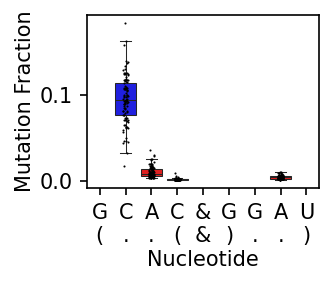

In [30]:
df_sub = df.query('m_sequence == "GCAC&GGAU"')
fig, ax = plt.subplots(figsize=(2.0, 1.5), dpi=150)
plot_motif_boxplot_stripplot(df_sub, show_structure=True, ax=ax)

<Axes: xlabel='Nucleotide', ylabel='Mutation Fraction'>

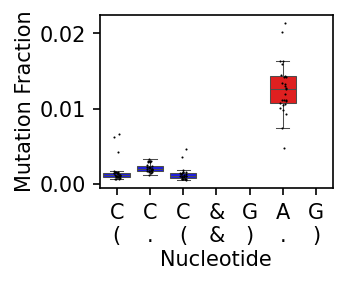

In [31]:
df_sub = df.query('m_sequence == "CCC&GAG"')
fig, ax = plt.subplots(figsize=(2.0, 1.5), dpi=150)
plot_motif_boxplot_stripplot(df_sub, show_structure=True, ax=ax)

In [32]:
example = df.query('m_sequence == "CCC&GAG"').iloc[0]
print(example)

both_purine                                                         False
both_pyrimidine                                                     False
constructs                                                   construct529
has_pdbs                                                             True
likely_pair                                                            CG
m_flank_bp_5p                                                          CG
m_flank_bp_3p                                                          CG
m_orientation                                                     flipped
m_pos                                                                   3
m_second_flank_bp_5p                                                   AU
m_second_flank_bp_3p                                                   GC
m_sequence                                                        CCC&GAG
m_structure                                                       (.(&).)
m_token                               

<Axes: xlabel='Nucleotide', ylabel='Mutation Fraction'>

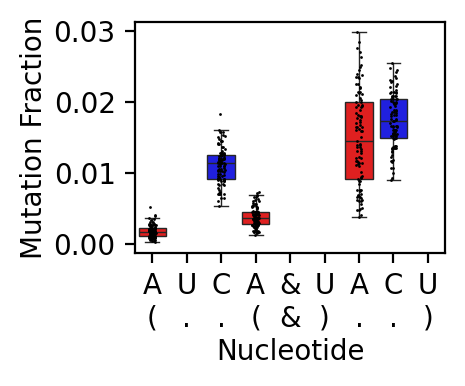

In [33]:
df_sub = df.query('m_sequence == "AUCA&UACU"')
fig, ax = plt.subplots(figsize=(2.0, 1.5), dpi=200)
plot_motif_boxplot_stripplot(df_sub, show_structure=True, ax=ax)

In [34]:
# Calculate the average, standard deviation, and count of r_data_ratio for each combination of r_stack and r_stack_other
summary_table = (
    df_ca_combined.groupby(["r_stack", "r_stack_other"])
    .agg(
        avg_ratio=("r_data_ratio", "mean"),
        std_ratio=("r_data_ratio", "std"),
        count=("r_data_ratio", "size"),
    )
    .reset_index()
)

# Sort the summary table by highest average ratio
summary_table = summary_table.sort_values(by="avg_ratio", ascending=False)

# Print the summary table using tabulate
print("Summary Table of r_stack and r_stack_other:")
print(
    tabulate(
        summary_table,
        headers=["r_stack", "r_stack_other", "Average Ratio", "Std Ratio", "Count"],
        floatfmt=".2f",
        tablefmt="pipe",
    )
)

Summary Table of r_stack and r_stack_other:
|    | r_stack   | r_stack_other   |   Average Ratio |   Std Ratio |   Count |
|---:|:----------|:----------------|----------------:|------------:|--------:|
| 39 | GU        | GA              |           37.15 |       35.47 |     100 |
|  6 | AC        | GG              |           18.61 |        8.74 |     197 |
| 13 | AU        | AG              |           15.05 |        7.63 |     200 |
|  2 | AA        | UG              |            6.22 |        3.65 |     197 |
| 10 | AG        | CG              |            4.59 |        2.14 |     203 |
| 17 | CA        | AG              |            4.24 |        2.75 |     196 |
| 33 | GG        | AC              |            3.81 |        2.09 |     103 |
| 30 | GC        | GA              |            3.22 |        2.41 |     396 |
| 41 | UA        | AA              |            3.13 |        2.32 |     201 |
| 36 | GU        | AA              |            3.09 |        4.86 |     394 |
|  3 | A

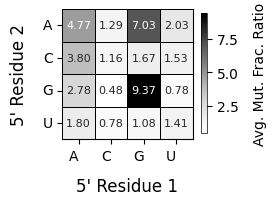

In [35]:
def create_heatmap(df, value_col, index_col, column_col, figsize=(2, 2)):
    # Create a pivot table for the heatmap
    pivot_table = df.pivot_table(
        values=value_col, index=index_col, columns=column_col, aggfunc="mean"
    )
    # Create the heatmap with improved aesthetics
    fig, ax = plt.subplots(figsize=figsize)
    heatmap = sns.heatmap(
        pivot_table,
        annot=True,
        cmap="Greys",
        fmt=".2f",
        cbar_kws={
            "label": f"Avg. {value_col}",
            "orientation": "vertical",
            "use_gridspec": False,  # This allows us to position the colorbar
            "location": "right",
            "pad": 0.01,  # Reduce space between heatmap and colorbar
        },
        ax=ax,
        annot_kws={"size": 8},  # Reduce the font size of the text in cells
        linewidths=0.5,  # Add lines between each cell
        linecolor="black",  # Set the color of the lines to black
        square=True,  # Ensure cells are square
    )
    # Remove the lines on the left and top
    ax.spines["left"].set_visible(False)
    ax.spines["top"].set_visible(False)
    # Keep the lines on the right and bottom
    ax.spines["right"].set_visible(True)
    ax.spines["bottom"].set_visible(True)

    # Adjust colorbar to match plot height
    cbar = heatmap.collections[0].colorbar
    cbar.ax.set_position([0.82, 0.15, 0.03, 0.7])  # Reduced width from 0.05 to 0.03
    cbar.outline.set_linewidth(0.5)
    cbar.outline.set_edgecolor("black")

    return fig, ax


fig, ax = create_heatmap(df_ca_combined, "r_data_ratio", "p5_res", "p5_res_other")
ax.set_xlabel(f"5' Residue 1", fontsize=12, labelpad=10)
ax.set_ylabel(f"5' Residue 2", fontsize=12, labelpad=10)

# Adjust tick labels and rotate y-axis labels
ax.set_xticklabels(ax.get_xticklabels(), rotation=0, ha="right")
ax.set_yticklabels(ax.get_yticklabels(), rotation=0)

# Set color bar label
cbar = ax.collections[0].colorbar
cbar.set_label("Avg. Mut. Frac. Ratio", fontsize=10, labelpad=10)

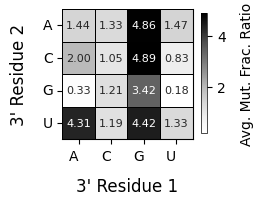

In [36]:
fig, ax = create_heatmap(df_ca_combined, "r_data_ratio", "p3_res", "p3_res_other")
ax.set_xlabel(f"3' Residue 1", fontsize=12, labelpad=10)
ax.set_ylabel(f"3' Residue 2", fontsize=12, labelpad=10)

# Adjust tick labels and rotate y-axis labels
ax.set_xticklabels(ax.get_xticklabels(), rotation=0, ha="right")
ax.set_yticklabels(ax.get_yticklabels(), rotation=0)

# Set color bar label
cbar = ax.collections[0].colorbar
cbar.set_label("Avg. Mut. Frac. Ratio", fontsize=10, labelpad=10)

In [37]:
display_heatmap_table(df_ca_combined, "p5_res", "p5_res_other", "r_data_ratio")

p5_res_other,A,C,G,U
p5_res,,,,
A,4.8,1.3,7.0,2.0
C,3.8,1.2,1.7,1.5
G,2.8,0.5,9.4,0.8
U,1.8,0.8,1.1,1.4
p5_res_other,A,C,G,U
p5_res,,,,
A,6.99,1.75,9.18,2.33
C,2.75,0.76,0.99,1.13
G,3.77,0.48,20.39,0.64


In [38]:
display_heatmap_table(df_ca_combined, "p3_res", "p3_res_other", "r_data_ratio")

p3_res_other,A,C,G,U
p3_res,,,,
A,1.4,1.3,4.9,1.5
C,2.0,1.1,4.9,0.8
G,0.3,1.2,3.4,0.2
U,4.3,1.2,4.4,1.3
p3_res_other,A,C,G,U
p3_res,,,,
A,1.50,1.15,3.42,1.05
C,1.71,0.88,7.74,0.54
G,0.30,1.83,2.63,0.13


### how does second flanking base pair composition affect the ratio

In [39]:
# GU and GA gives the highest ratios
df_gu_stack = df_ca_combined.query(
    "r_stack == 'GU' and r_stack_other == 'GA' and m_token == '2x2'"
)
display_heatmap_table(
    df_gu_stack, "m_second_flank_bp_5p", "m_second_flank_bp_3p", "r_data_ratio"
)

m_second_flank_bp_3p,AU,CG,GC,UA
m_second_flank_bp_5p,,,,
AU,52.4,23.6,104.8,29.2
CG,18.2,10.7,16.7,10.6
GC,50.9,25.6,nan,37.7
UA,58.5,21.1,48.3,30.5
m_second_flank_bp_3p,AU,CG,GC,UA
m_second_flank_bp_5p,,,,
AU,30.50,17.81,120.19,24.18
CG,7.57,4.39,nan,5.40
GC,26.73,6.53,nan,20.62


In [40]:
# just look at GU
df_gu_stack = df_ca_combined.query("r_stack == 'GU' and m_token == '2x2'")
display_heatmap_table(
    df_gu_stack, "m_second_flank_bp_5p", "m_second_flank_bp_3p", "r_data_ratio"
)

m_second_flank_bp_3p,AU,CG,GC,UA
m_second_flank_bp_5p,,,,
AU,6.7,2.7,9.1,4.2
CG,3.1,2.1,2.0,2.9
GC,6.6,3.7,1.2,5.8
UA,10.2,4.1,7.2,4.6
m_second_flank_bp_3p,AU,CG,GC,UA
m_second_flank_bp_5p,,,,
AU,18.51,7.40,39.97,11.51
CG,5.48,3.16,3.47,4.31
GC,17.28,7.66,0.99,14.09


In [41]:
# just look at GA
df_gu_stack = df_ca_combined.query("r_stack_other == 'GA' and m_token == '2x2'")
display_heatmap_table(
    df_gu_stack, "m_second_flank_bp_5p", "m_second_flank_bp_3p", "r_data_ratio"
)

m_second_flank_bp_3p,AU,CG,GC,UA
m_second_flank_bp_5p,,,,
AU,8.9,4.2,10.8,6.3
CG,4.7,3.4,3.9,4.3
GC,7.7,3.4,1.9,6.9
UA,8.9,5.0,6.3,5.2
m_second_flank_bp_3p,AU,CG,GC,UA
m_second_flank_bp_5p,,,,
AU,19.35,8.94,40.87,13.61
CG,6.21,3.17,3.68,4.31
GC,17.01,6.60,1.34,14.38


In [42]:
# look at the whole set
display_heatmap_table(
    df_ca_combined, "m_second_flank_bp_5p", "m_second_flank_bp_3p", "r_data_ratio"
)

m_second_flank_bp_3p,AU,CG,GC,UA
m_second_flank_bp_5p,,,,
AU,2.6,1.8,2.3,1.9
CG,2.2,1.9,2.0,1.9
GC,2.3,1.7,1.7,1.8
UA,2.8,2.0,2.4,2.2
m_second_flank_bp_3p,AU,CG,GC,UA
m_second_flank_bp_5p,,,,
AU,6.57,3.83,10.81,4.08
CG,3.94,3.64,3.49,3.12
GC,6.03,3.28,3.06,4.73


# single mismatches

In [43]:
df_ca_1x1 = df.query(
    "r_nuc == 'C' and r_type == 'NON-WC' and likely_pair == 'CA' and m_token == '1x1'"
).copy()
df_ac_1x1 = df.query(
    "r_nuc == 'A' and r_type == 'NON-WC' and likely_pair == 'AC' and m_token == '1x1'"
).copy()

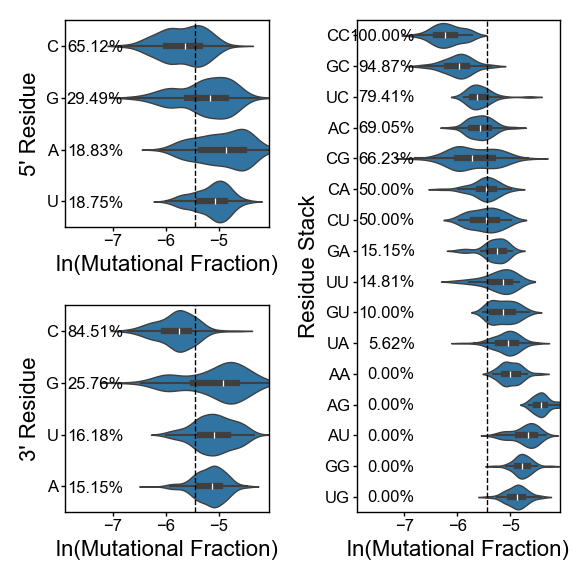

In [44]:
df_ca_1x1 = df.query(
    "r_nuc == 'C' and r_type == 'NON-WC' and likely_pair == 'CA' and m_token == '1x1'"
).copy()
plot_residue_trends(df_ca_1x1, color="tab:blue")

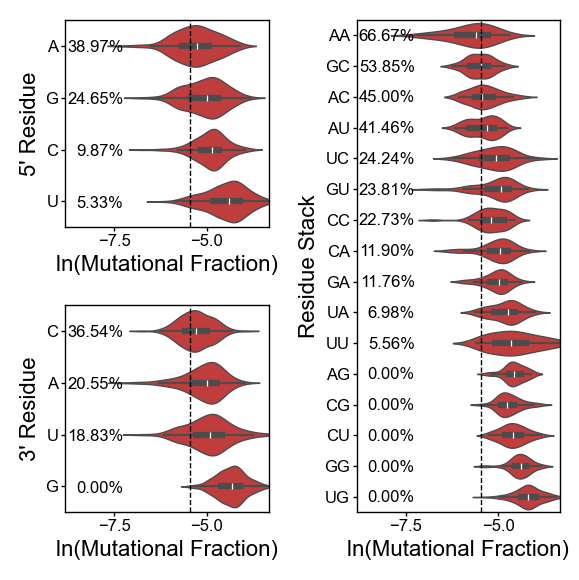

In [45]:
plot_residue_trends(df_ac_1x1, color="tab:red")

In [46]:
create_summary_table(df_ca_1x1, "r_stack")

Summary table for r_stack:
| r_stack   | % Under -5.45   |   Count |
|:----------|:----------------|--------:|
| CC        | 100.00%         |      27 |
| GC        | 94.87%          |      39 |
| UC        | 79.41%          |      34 |
| AC        | 69.05%          |      42 |
| CG        | 66.23%          |      77 |
| CU        | 50.00%          |      28 |
| CA        | 50.00%          |      40 |
| GA        | 15.15%          |      33 |
| UU        | 14.81%          |      27 |
| GU        | 10.00%          |      40 |
| UA        | 5.62%           |      89 |
| AU        | 0.00%           |      41 |
| AA        | 0.00%           |      36 |
| AG        | 0.00%           |      35 |
| UG        | 0.00%           |      42 |
| GG        | 0.00%           |      44 |


# 2x2 double mismatches

In [47]:
df_ca_2x2 = df.query(
    "r_nuc == 'C' and r_type == 'NON-WC' and likely_pair == 'CA' and m_token == '2x2'"
).copy()
df_ac_2x2 = df.query(
    "r_nuc == 'A' and r_type == 'NON-WC' and likely_pair == 'AC' and m_token == '2x2'"
).copy()

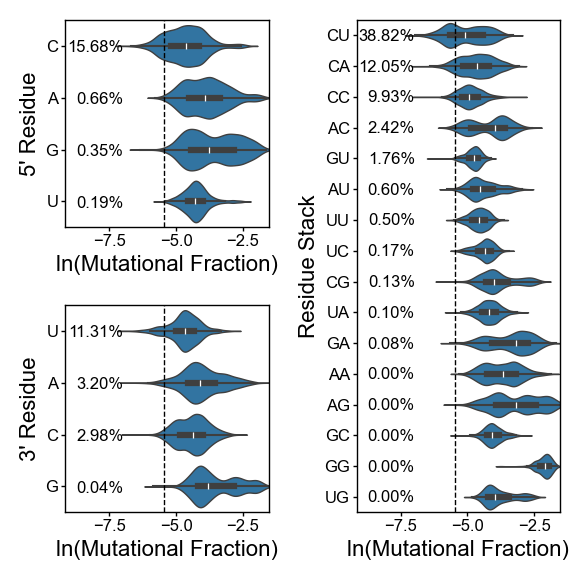

In [48]:
plot_residue_trends(df_ca_2x2, color="tab:blue")

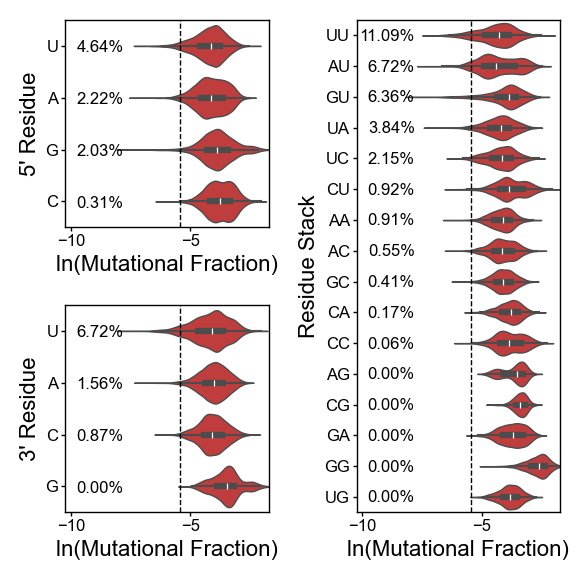

In [49]:
plot_residue_trends(df_ac_2x2, color="tab:red")

# with PDB info with known pairs

## C reactivity trends

In [50]:
df_pdb_ca = df_pdb.query(
    "r_nuc == 'C' and r_type == 'NON-WC' and pdb_r_pair == 'C-A' and no_of_interactions == 1"
).copy()
print(len(df_pdb_ca["m_sequence"].unique()))

24


In [64]:
df_pdb_ca = df_pdb.query(
    "r_nuc == 'C' and r_type == 'NON-WC' and pdb_r_pair == 'C-A' and no_of_interactions == 1"
).copy()
df_pdb_ca.groupby("pdb_r_bp_type").agg(
    ln_r_data_mean=("ln_r_data", "mean"),
    ln_r_data_std=("ln_r_data", "std"),
    count=("ln_r_data", "size"),
)

,ln_r_data_mean,ln_r_data_std,count
pdb_r_bp_type,,,
cSW,-5.985255,0.270905,46
cWH,-3.206262,0.204072,208
cWW,-4.659214,0.864945,1709
cWW_p,-4.552957,0.575209,375
tSH,-5.582941,0.637909,415
tWH,-5.832151,0.555817,154


<Axes: xlabel='pdb_r_bp_type', ylabel='ln_r_data'>

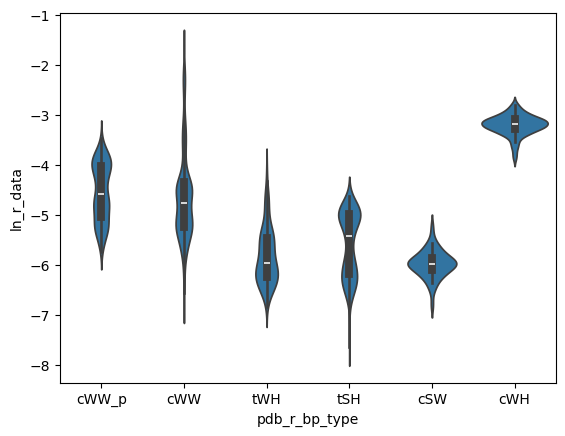

In [63]:
sns.violinplot(x="pdb_r_bp_type", y="ln_r_data", data=df_pdb_ca)

In [62]:
df_pdb_ca_sub = df_pdb_ca.dropna(subset=["pdb_path", "pdb_r_bp_type", "ln_r_data"])
df_sub_1 = (
    df_pdb_ca_sub.groupby("pdb_r_bp_type")
    .agg(
        ln_r_data_min=("ln_r_data", "min"),
        ln_r_data_max=("ln_r_data", "max"),
    )
    .reset_index()
)

data = []
for i, g in df_pdb_ca_sub.groupby("pdb_r_bp_type"):
    row_min = g.loc[g["ln_r_data"].idxmin()]
    row_max = g.loc[g["ln_r_data"].idxmax()]
    data.append([i, row_min["pdb_path"], row_max["pdb_path"]])
df_sub_2 = pd.DataFrame(data)
df_sub_2.columns = ["pdb_r_bp_type", "min_pdb_path", "max_pdb_path"]
df_sub_final = pd.merge(
    df_sub_1, df_sub_2, left_on="pdb_r_bp_type", right_on="pdb_r_bp_type", how="left"
)

# Format the DataFrame as a tabulate table
table = tabulate(df_sub_final, headers="keys", tablefmt="pipe", showindex=False)

# Print the formatted table
print(table)

| pdb_r_bp_type   |   ln_r_data_min |   ln_r_data_max | min_pdb_path                                                      | max_pdb_path                                                      |
|:----------------|----------------:|----------------:|:------------------------------------------------------------------|:------------------------------------------------------------------|
| cSW             |        -6.8034  |        -5.25143 | data/pdbs_w_2bp/CCG_UAG/TWOWAY.5ZTM.1-1.UAG-CCG.0.pdb             | data/pdbs_w_2bp/CCG_UAG/TWOWAY.5ZTM.1-1.UAG-CCG.0.pdb             |
| cWH             |        -3.88782 |        -2.78401 | data/pdbs_w_2bp/UCACAG_UCACAG/TWOWAY.1KD4.4-4.UCACAG-UCACAG.0.pdb | data/pdbs_w_2bp/UCACAG_UCACAG/TWOWAY.1KD4.4-4.UCACAG-UCACAG.0.pdb |
| cWW             |        -6.77673 |        -1.68962 | data/pdbs_w_2bp/CCC_GAG/TWOWAY.6IA2.1-1.CCC-GAG.0.pdb             | data/pdbs_w_2bp/GCAC_GGAU/TWOWAY.6ZVI.2-2.GGAU-GCAC.0.pdb         |
| cWW_p           |        -5.74148 |   

### stacking

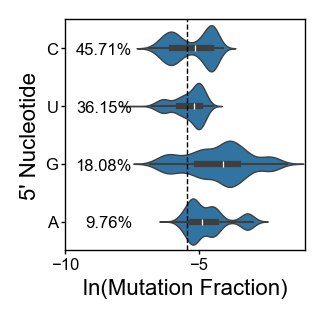

In [52]:
df_pdb_ca = df_pdb.query(
    "r_nuc == 'C' and r_type == 'NON-WC' and pdb_r_pair == 'C-A' and no_of_interactions == 1"
).copy()
ax = plot_violins_w_percent(
    df_pdb_ca,
    "ln_r_data",
    "p5_res",
    color="tab:blue",
    gt_lt="less",
    xlim=(-10, -1),
    sorted_by_mean=True,
)
ax.set_ylabel("5' Nucleotide", labelpad=2)
ax.set_xlabel("ln(Mutation Fraction)", labelpad=2)
format_small_plot(ax)

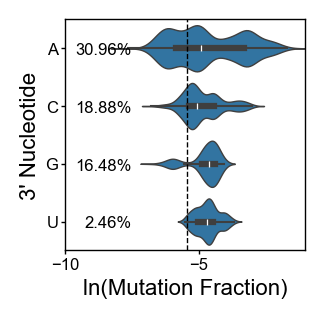

In [53]:
df_pdb_ca = df_pdb.query(
    "r_nuc == 'C' and r_type == 'NON-WC' and pdb_r_pair == 'C-A' and no_of_interactions == 1"
).copy()
ax = plot_violins_w_percent(
    df_pdb_ca,
    "ln_r_data",
    "p3_res",
    color="tab:blue",
    gt_lt="less",
    xlim=(-10, -1),
    sorted_by_mean=True,
)
ax.set_ylabel("3' Nucleotide", labelpad=2)
ax.set_xlabel("ln(Mutation Fraction)", labelpad=2)
format_small_plot(ax)

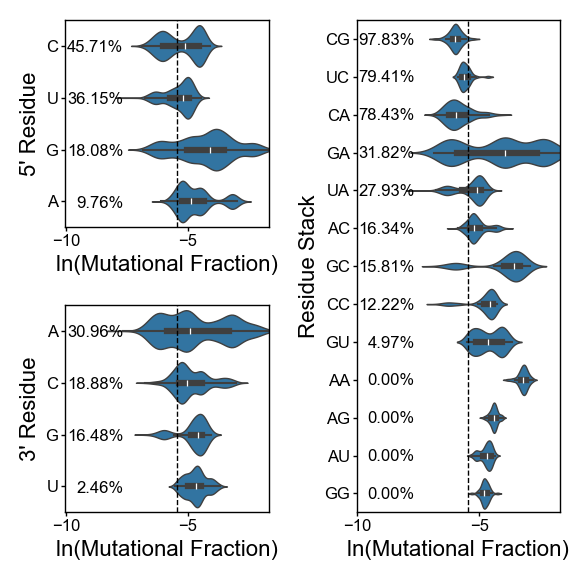

In [54]:
df_pdb_ca = df_pdb.query(
    "r_nuc == 'C' and r_type == 'NON-WC' and pdb_r_pair == 'C-A' and no_of_interactions == 1"
).copy()
plot_residue_trends(df_pdb_ca, color="tab:blue")

In [55]:
create_summary_table(df_pdb_ca, "r_stack")

Summary table for r_stack:
| r_stack   | % Under -5.45   |   Count |
|:----------|:----------------|--------:|
| CG        | 97.83%          |      46 |
| UC        | 79.41%          |      68 |
| CA        | 78.43%          |     153 |
| GA        | 31.82%          |     308 |
| UA        | 27.93%          |     358 |
| AC        | 16.34%          |     759 |
| GC        | 15.81%          |     234 |
| CC        | 12.22%          |     221 |
| GU        | 4.97%           |     161 |
| AU        | 0.00%           |     164 |
| AG        | 0.00%           |     139 |
| GG        | 0.00%           |      88 |
| AA        | 0.00%           |     208 |


In [56]:
create_summary_table(df_pdb_ca, "m_token")

Summary table for m_token:
| m_token   | % Under -5.45   |   Count |
|:----------|:----------------|--------:|
| 3x3       | 99.03%          |     103 |
| 3x1       | 36.00%          |      50 |
| 1x1       | 31.65%          |     635 |
| 4x4       | 23.71%          |     831 |
| 2x2       | 11.82%          |     804 |
| 2x1       | 0.00%           |     172 |
| 4x3       | 0.00%           |     104 |
| 5x3       | 0.00%           |     104 |
| 3x2       | 0.00%           |     104 |


In [57]:
create_summary_table(df_pdb_ac, "m_token")

Summary table for m_token:
| m_token   | % Under -5.45   |   Count |
|:----------|:----------------|--------:|
| 4x3       | 49.04%          |     208 |
| 3x2       | 29.81%          |     312 |
| 1x1       | 25.67%          |     635 |
| 3x1       | 21.76%          |     170 |
| 4x4       | 11.91%          |     831 |
| 5x3       | 11.54%          |     104 |
| 2x2       | 9.45%           |     804 |
| 1x0       | 1.90%           |     105 |
| 2x1       | 0.00%           |     250 |
| 3x3       | 0.00%           |     103 |
| 5x0       | 0.00%           |     104 |
| 2x0       | 0.00%           |      81 |


In [58]:
create_summary_table(df_pdb_ac, "side_diff")

Summary table for side_diff:
|   side_diff | % Under -5.45   |   Count |
|------------:|:----------------|--------:|
|           1 | 22.51%          |     875 |
|           0 | 14.24%          |    2373 |
|           2 | 13.80%          |     355 |
|           5 | 0.00%           |     104 |


(<Figure size 400x300 with 1 Axes>,
 <Axes: xlabel='ln(Mutation Fraction)', ylabel='Diff. in num nucleotides'>)

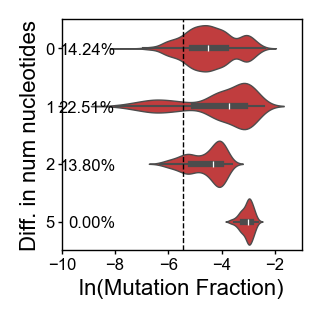

In [59]:
plot_side_diff_violinplot(df_pdb_ac.query("m_token != '6x3'"), color="tab:red")

### Are A and C reactivity the correlated in a pair

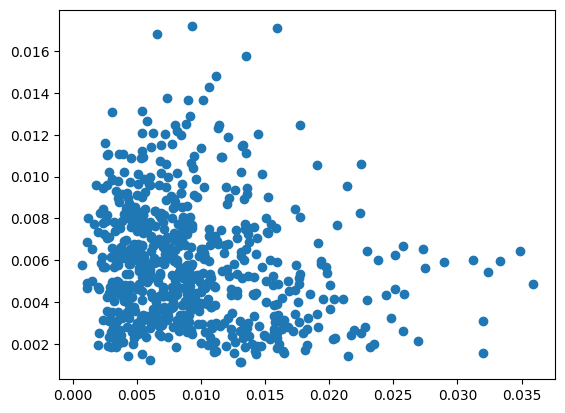

In [60]:
df_ca_1x1 = df.query(
    "(likely_pair == 'CA' or likely_pair == 'AC') and m_token == '1x1'"
).copy()
data = []
m_seqs = []
for i, g in df_ca_1x1.groupby(["m_sequence", "constructs"]):
    if len(g) != 2:
        continue
    if g.iloc[0]["r_nuc"] == "A":
        data.append([g.iloc[0]["r_data"], g.iloc[1]["r_data"]])
    else:
        data.append([g.iloc[1]["r_data"], g.iloc[0]["r_data"]])
    m_seqs.append(g.iloc[0]["m_sequence"])
data = np.array(data)
plt.scatter(data[:, 0], data[:, 1])

In [61]:
df_ca = df.query("l'")

SyntaxError: EOL while scanning string literal (<unknown>, line 1)

## distance between A and C atoms

In [69]:
df_dist = pd.read_csv("../data/pdb-features/distances_all.csv")

In [96]:
def calculate_atom_distances(df, df_dist, r_atom, pair_atom):
    data = []
    for i, g in df.groupby(["pdb_name", "pdb_r_pos"]):
        row = g.iloc[0]
        if row["pair_pdb_r_pos"] == -1:
            continue
        if row.pdb_r_pos < row.pair_pdb_r_pos:
            df_sub = df_dist.query(
                f'pdb_name == "{row.pdb_name}" and '
                f"res_num1 == {row.pdb_r_pos} and res_num2 == {row.pair_pdb_r_pos} and "
                f'atom_name1 == "{r_atom}" and atom_name2 == "{pair_atom}"'
            )
        else:
            df_sub = df_dist.query(
                f'pdb_name == "{row.pdb_name}" and '
                f"res_num1 == {row.pair_pdb_r_pos} and res_num2 == {row.pdb_r_pos} and "
                f'atom_name1 == "{r_atom}" and atom_name2 == "{pair_atom}"'
            )
        if len(df_sub) == 0:
            # print("couldnt find distance")
            continue
        data.append(
            {
                "pdb_name": row.pdb_path,
                "pdb_r_pos": row.pdb_r_pos,
                "pair_pdb_r_pos": row.pair_pdb_r_pos,
                "pdb_r_bp_type": row.pdb_r_bp_type,
                "distance": df_sub.iloc[0]["distance"],
                "pdb_res": row.pdb_res,
                "ln_r_data_mean": g["ln_r_data"].mean(),
                "ln_r_data_std": g["ln_r_data"].std(),
            }
        )
    return pd.DataFrame(data)


# Example usage:
df_dist_ca = calculate_atom_distances(df_pdb_ca, df_dist, "C2'", "C2'")

Text(0.5, 1.0, 'Distance vs Ratio of ln(r_data) (R² = 0.462)')

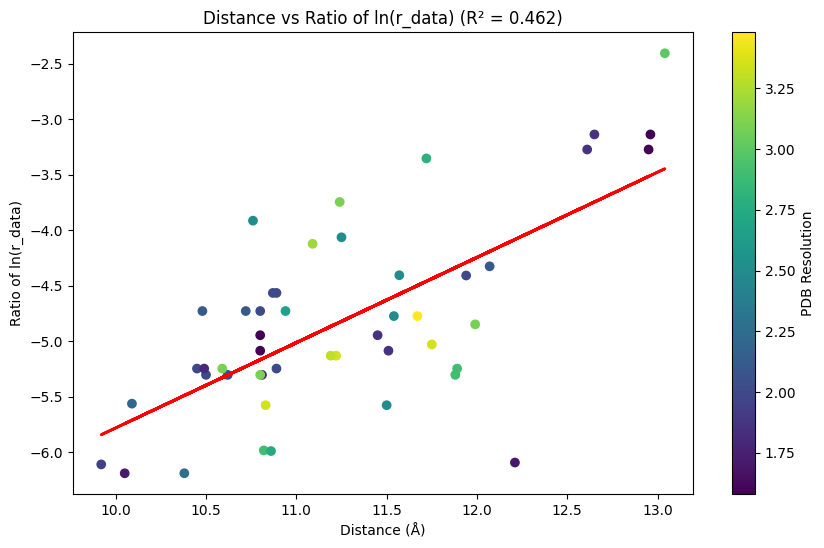

In [99]:
# Prepare the data
X = df_dist_ca["distance"].values.reshape(-1, 1)
y = df_dist_ca["ln_r_data_mean"].values

# Remove any rows with NaN values
mask = ~np.isnan(X).any(axis=1) & ~np.isnan(y)
X = X[mask]
y = y[mask]
pdb_res = df_dist_ca["pdb_res"].values[mask]

# Fit linear regression model
model = LinearRegression()
model.fit(X, y)

# Compute R-squared
r2 = r2_score(y, model.predict(X))

# Create scatter plot
plt.figure(figsize=(10, 6))
scatter = plt.scatter(X.flatten(), y, c=pdb_res, cmap="viridis")
cbar = plt.colorbar(scatter)
cbar.set_label("PDB Resolution")

# Add regression line
plt.plot(X, model.predict(X), color="red", linewidth=2)

plt.xlabel("Distance (Å)")
plt.ylabel("Ratio of ln(r_data)")
plt.title(f"Distance vs Ratio of ln(r_data) (R² = {r2:.3f})")

In [105]:
df_dist_ca.sort_values("distance", ascending=True, inplace=True)

In [107]:
print(df_dist_ca.iloc[2]["pdb_name"])
print(df_dist_ca.iloc[2]["pdb_r_pos"])
print(df_dist_ca.iloc[2]["distance"])
print(df_dist_ca.iloc[2]["ln_r_data_mean"])

data/pdbs_w_2bp/ACC_GAU/TWOWAY.1TFW.1-1.ACC-GAU.0.pdb
4
10.09
-5.563908012338095


In [108]:
print(df_dist_ca.iloc[-1]["pdb_name"])
print(df_dist_ca.iloc[-1]["pdb_r_pos"])
print(df_dist_ca.iloc[-1]["distance"])
print(df_dist_ca.iloc[-1]["ln_r_data_mean"])

data/pdbs_w_2bp/GCAC_GGAU/TWOWAY.6ZVI.2-2.GGAU-GCAC.0.pdb
4
13.04
-2.40707401552


In [81]:
def calculate_atom_distances_with_ratio(df, df_dist, r_atom, pair_atom, df_pdb):
    data_ratio = []
    seen = []
    for i, g in df.groupby(["pdb_name", "pdb_r_pos"]):
        row = g.iloc[0]
        if row["pair_pdb_r_pos"] == -1:
            continue
        if row.pdb_r_pos < row.pair_pdb_r_pos:
            df_sub = df_dist.query(
                f'pdb_name == "{row.pdb_name}" and '
                f"res_num1 == {row.pdb_r_pos} and res_num2 == {row.pair_pdb_r_pos} and "
                f'atom_name1 == "{r_atom}" and atom_name2 == "{pair_atom}"'
            )
        else:
            df_sub = df_dist.query(
                f'pdb_name == "{row.pdb_name}" and '
                f"res_num1 == {row.pair_pdb_r_pos} and res_num2 == {row.pdb_r_pos} and "
                f'atom_name1 == "{pair_atom}" and atom_name2 == "{r_atom}"'
            )
        if len(df_sub) == 0:
            continue

        key = (row.pdb_name, row.pdb_r_pos, row.pair_pdb_r_pos)
        partner_key = (row.pdb_name, row.pair_pdb_r_pos, row.pdb_r_pos)
        if key in seen or partner_key in seen:
            continue
        seen.append(key)
        seen.append(partner_key)
        partner_g = df_pdb.query(
            f'pdb_name == "{row.pdb_name}" and pdb_r_pos == {row.pair_pdb_r_pos}'
        )
        if len(partner_g) == 0:
            print("couldnt find partner")
            continue
        ratio = g["ln_r_data"].mean() / partner_g["ln_r_data"].mean()
        data_ratio.append(
            {
                "pdb_name": row.pdb_path,
                "pdb_r_pos": row.pdb_r_pos,
                "pair_pdb_r_pos": row.pair_pdb_r_pos,
                "distance": df_sub.iloc[0]["distance"],
                "pdb_res": row.pdb_re,
                "ratio": ratio,
            }
        )

    return pd.DataFrame(data_ratio)

In [115]:
df_dist_ratio_ca = calculate_atom_distances_with_ratio(
    df_pdb_ca, df_dist, "O2'", "P", df_pdb
)

Text(0.5, 1.0, 'Distance vs Ratio of ln(r_data) (R² = 0.627)')

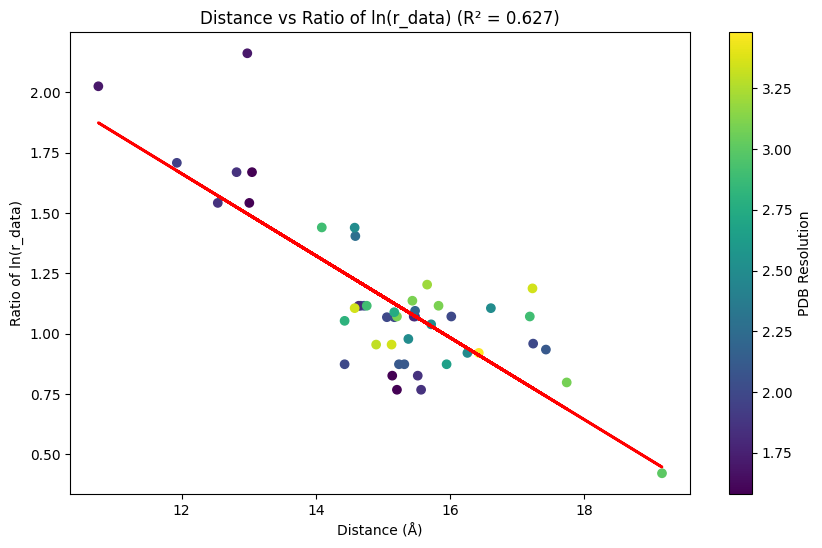

In [117]:
# Prepare the data
X = df_dist_ratio_ca["distance"].values.reshape(-1, 1)
y = df_dist_ratio_ca["ratio"].values

# Remove any rows with NaN values
mask = ~np.isnan(X).any(axis=1) & ~np.isnan(y)
X = X[mask]
y = y[mask]
pdb_res = df_dist_ratio_ca["pdb_res"].values[mask]

# Fit linear regression model
model = LinearRegression()
model.fit(X, y)

# Compute R-squared
r2 = r2_score(y, model.predict(X))

# Create scatter plot
plt.figure(figsize=(10, 6))
scatter = plt.scatter(X.flatten(), y, c=pdb_res, cmap="viridis")
cbar = plt.colorbar(scatter)
cbar.set_label("PDB Resolution")

# Add regression line
plt.plot(X, model.predict(X), color="red", linewidth=2)

plt.xlabel("Distance (Å)")
plt.ylabel("Ratio of ln(r_data)")
plt.title(f"Distance vs Ratio of ln(r_data) (R² = {r2:.3f})")

In [118]:
df_dist_ratio_ca.sort_values("distance", ascending=True, inplace=True)

In [119]:
print(df_dist_ratio_ca.iloc[0]["pdb_name"])
print(df_dist_ratio_ca.iloc[0]["pdb_r_pos"])
print(df_dist_ratio_ca.iloc[0]["distance"])
print(df_dist_ratio_ca.iloc[0]["ratio"])

data/pdbs_w_2bp/AAGCAG_UCAGGU/TWOWAY.1LNT.4-4.UCAGGU-AAGCAG.0.pdb
14
10.76
2.024952875824488


In [120]:
print(df_dist_ratio_ca.iloc[-1]["pdb_name"])
print(df_dist_ratio_ca.iloc[-1]["pdb_r_pos"])
print(df_dist_ratio_ca.iloc[-1]["distance"])
print(df_dist_ratio_ca.iloc[-1]["ratio"])

data/pdbs_w_2bp/GCAC_GGAU/TWOWAY.6ZVI.2-2.GGAU-GCAC.0.pdb
4
19.16
0.42199456618046494
